# Анализ датасета [MyAnimeList Dataset]()

In [ ]:
import warnings
import scipy
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api
import random

В рамках данного проекта я буду анализировать датасет полученный из популярного сайта для просмотра аниме - MyAnimeList (MAL). Рассмотрим файлы, с которыми я буду работать.

In [ ]:
#скачиваю файлы из гугл диска

url = 'https://drive.google.com/uc?id=1Z7twLGEcMRQItPKyBKin66AhjT9koOwC'
gdown.download(url,'./anime_cleaned.csv', quiet=False, fuzzy=True)

url = 'https://drive.google.com/uc?id=1Fk7JqFGEmL-7luaTVBn370dudNHcF9fG'
gdown.download(url, './animelists_cleaned.csv', quiet=False, fuzzy=True)

url = 'https://drive.google.com/uc?id=1nx_FOdYFqwlQmf_LLfmjMo5X88rlEQpw'
gdown.download(url, './users_cleaned.csv', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Z7twLGEcMRQItPKyBKin66AhjT9koOwC
To: /content/anime_cleaned.csv
100%|██████████| 6.33M/6.33M [00:00<00:00, 69.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fk7JqFGEmL-7luaTVBn370dudNHcF9fG
To: /content/animelists_cleaned.csv
100%|██████████| 392M/392M [00:04<00:00, 92.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nx_FOdYFqwlQmf_LLfmjMo5X88rlEQpw
To: /content/users_cleaned.csv
100%|██████████| 15.7M/15.7M [00:00<00:00, 83.1MB/s]


'./users_cleaned.csv'

Во-первых, это файл с различной информацией об аниме, доступных на сайте : название на разных языках, количество сезонов/серий, жанр, место в рейтинге популярности и т.д.
Из него сразу убираю, на первый взгляд, бесполезные столбцы.

In [ ]:
anime_info = pd.read_csv("./anime_cleaned.csv")
anime_info= anime_info.drop(['image_url','related','broadcast'],axis='columns')
anime_info

,anime_id,title,title_english,title_japanese,title_synonyms,type,source,episodes,status,airing,...,background,premiered,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,TV,Manga,12,Finished Airing,False,...,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,TV,Manga,26,Finished Airing,False,...,NaN,Spring 2007,"TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",TV,Manga,51,Finished Airing,False,...,NaN,Fall 2008,"TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,TV,Original,38,Finished Airing,False,...,Princess Tutu aired in two parts. The first pa...,Summer 2002,"Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,TV,Manga,25,Finished Airing,False,...,NaN,Fall 2012,"NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,NaN,dokidokiりとる大家さん,NaN,OVA,Other,0,Currently Airing,True,...,NaN,NaN,NaN,NaN,Collaboration Works,Hentai,[],[],30.0,2018.0
6664,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,我是江小白 小剧场,Wo Shi Jiang Xiao Bai: Xiao Ju Chang,ONA,Original,1,Finished Airing,False,...,NaN,NaN,NaN,NaN,2:10 Animation,"Slice of Life, Drama, Romance",[],[],0.0,2018.0
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,NaN,げんきげんきノンタン おばけむらめいろ,NaN,OVA,Original,1,Finished Airing,False,...,NaN,NaN,NaN,NaN,Polygon Pictures,"Music, Kids",[],[],35.0,2015.0
6666,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,ONA,Picture book,0,Currently Airing,True,...,NaN,NaN,NaN,NaN,Sanrio,Kids,[],[],2.0,2013.0


Во-вторых, это файл со всеми юзерами сайта, их просмотренными аниме, выставленным оценками. При попытке прочитать полноценный файл в dataframe, оперативная память в коллабе почти заполнилась. Потому я предварительно к загрузке удалил ненужные в анализе столбцы в целях снижения веса файла. Также я убрал все строки, где выставленные оценки за аниме = 0, т.к посчитал это bias для анализа (39 процентов оценок составили 0)


In [ ]:
c_size = 2000000
animelist = pd.read_csv("./animelists_cleaned.csv", chunksize=c_size)
animelist = pd.concat(animelist, ignore_index=True)
animelist.head()

,username,anime_id,my_score,my_rewatching
0,karthiga,21,9,NaN
1,karthiga,59,7,NaN
2,karthiga,74,7,NaN
3,karthiga,120,7,NaN
4,karthiga,178,7,0.0


И файл с общей информацией о юзерах: пол, количество оцененных аниме, средняя оценка за все аниме и т.д

In [ ]:
animeusers = pd.read_csv("./users_cleaned.csv")
animeusers = animeusers.set_index('username')
animeusers.head()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
username,,,,,,,,,,,,,,,,
karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


Во-первых, мне стало интересно какие аниме имеют самые высокие оценки, яв-ся самыми популярными и другие характеристики (в дальнейшем под популярностью будет иметься в виду столбец members,который показывает сколько пользователей добавили данное аниме в свой лист просмотренных аниме) .

In [ ]:
min_id = anime_info[anime_info['score']!=0][['score']].idxmin() #idxmax выдает индекс строки с наибольшим элементом

print('Топ 5 аниме с самым высоким рейтингом :')
print(anime_info.iloc[anime_info['score'].nlargest(5).index.tolist()][['title','score']])

max_id = anime_info[['popularity']].idxmax()
print(f'\nТоп5 самых популярных аниме:')
print(anime_info.iloc[anime_info['members'].nlargest(5).index.tolist()][['title','members']])
max_id = anime_info[['episodes']].idxmax()
print(f'\nАниме с наибольшим количеством эпизодов- {list(anime_info.iloc[max_id,1])[0]} ({list(anime_info.iloc[max_id,7])[0]} episodes)')
max_id = anime_info[['aired_from_year']].idxmin()
print(f'Самое старое аниме- {list(anime_info.iloc[max_id,1])[0]} ({list(anime_info.iloc[max_id,-1])[0]} year)')
longest_name = anime_info['title'][anime_info['title'].str.split().str.len().idxmax()]
print(f'Аниме с самым длинным названием- {longest_name}')
anime_copy= animelist.copy()
anime_copy = anime_copy[anime_copy['my_rewatching'].notna()]
anime_copy = anime_copy[anime_copy['my_rewatching']!=0]
most_rewatched=anime_copy[['anime_id','my_rewatching']].value_counts().head(5).to_frame()
print('\nТоп5 самых пересматриваемых аниме')
print(pd.merge(most_rewatched, anime_info, on="anime_id")['title'])
del min_id, max_id, longest_name, anime_copy, most_rewatched

Топ 5 аниме с самым высоким рейтингом :
                                 title  score
6663           Dokidoki Little Ooyasan   9.52
1261  Fullmetal Alchemist: Brotherhood   9.25
529                     Kimi no Na wa.   9.19
639                           Gintama°   9.15
2953                     Steins;Gate 0   9.15

Топ5 самых популярных аниме:
                                 title  members
3802                        Death Note  1456378
3897                Shingeki no Kyojin  1345842
3009                  Sword Art Online  1301616
1261  Fullmetal Alchemist: Brotherhood  1199091
4215                     One Punch Man  1020754

Аниме с наибольшим количеством эпизодов- Oyako Club (1818 episodes)
Самое старое аниме- Fuku-chan no Kishuu (1942.0 year)
Аниме с самым длинным названием- Baka na Imouto wo Rikou ni Suru no wa Ore no xx dake na Ken ni Tsuite

Топ5 самых пересматриваемых аниме
0    Fullmetal Alchemist: Brotherhood
1                          Death Note
2              Hunter x Hunte

Интересно посмотреть распределение аниме по различным параметрам. Например, по жанру, возрастной категории, по источнику сюжета и формату аниме.

rating meanings

G-13 - Teens 13 or older

PG - Children

G - All Ages

R+ - Mild Nudity

R - 17+ (violence & profanity)

Rx - Hentai

None

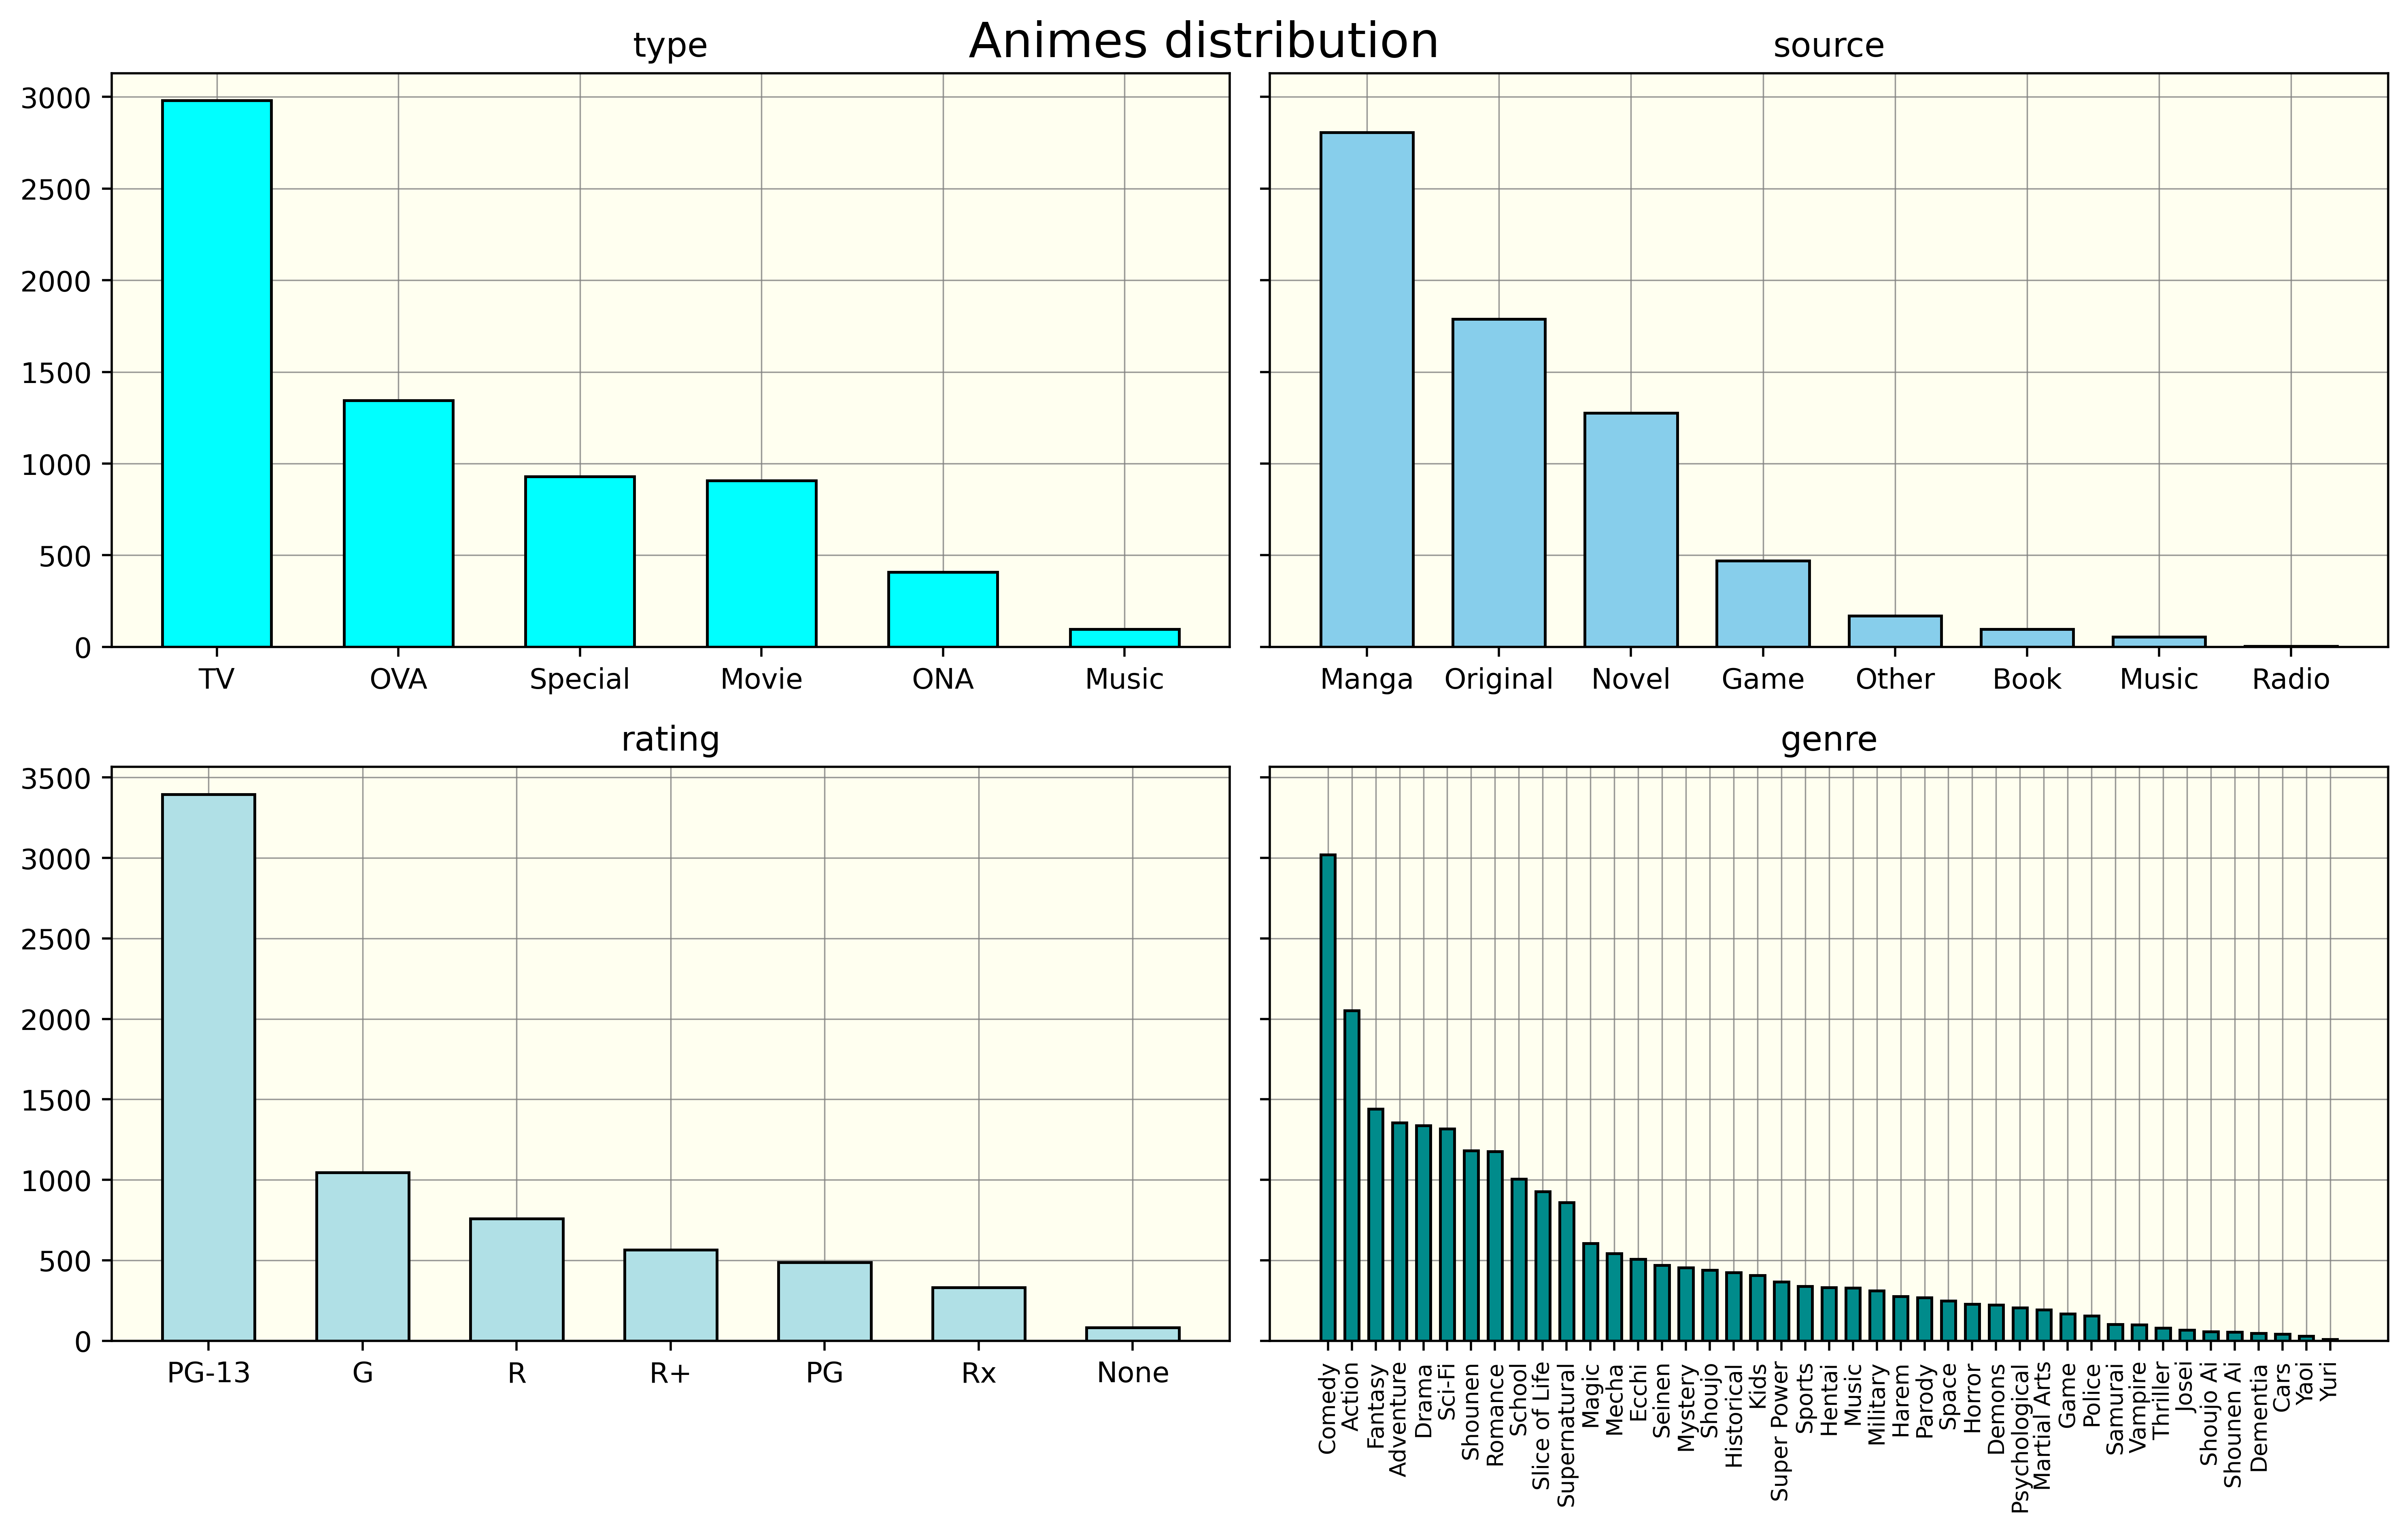

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey="row",dpi=500)
#setting design of graphs
rows, cols = 2, 2
for i in range(rows):
  for j in range(cols):
      ax[i,j].grid(linewidth=0.5,alpha=0.8,color='grey') #сетка
      ax[i,j].set_axisbelow(True) #чтобы сетка не было поверх графика
      ax[i,j].set_facecolor('ivory') #фоновый цвет
#Left top
plt.subplot(2, 2, 1) #выбираю координату, над которой работаю
counts= anime_info["type"].value_counts() #counts occurances of each element in pandas series
plt.bar(counts.index, counts.values,edgecolor='black',width=0.6,color='cyan')
plt.title('type')
#Right top
plt.subplot(2, 2, 2)
rep_manga,rep_book,rep_novel=['4-koma manga','Digital manga','Web manga'],['Picture book'],['Light novel','Visual novel']
anime_info_copy = anime_info.copy().replace(rep_manga,'Manga').replace(rep_book,'Book').replace(rep_novel,'Novel').replace('Card game','Game')
counts= anime_info_copy["source"].value_counts()
plt.bar(counts.index, counts.values,edgecolor='black', width=0.7,color='skyblue')
plt.title('source')
#Left bottom
plt.subplot(2, 2, 3)
counts= anime_info["rating"].str.split().str[0].value_counts()
plt.bar(counts.index, counts.values,edgecolor='black',width=0.6,color='powderblue')
plt.title('rating')
#Right bottom
plt.subplot(2, 2, 4)
counts= anime_info["genre"].str.split(', ').explode().reset_index(drop=True).value_counts()
plt.bar(counts.index,counts.values,edgecolor='black',width=0.6,color='darkcyan')
plt.tick_params(labelrotation=90,labelsize=8)
plt.title('genre')
plt.suptitle('Animes distribution',y=0.94,fontsize='xx-large')
plt.tight_layout()

Ожидаемо большая часть аниме предназначены для просмотра по телевидению, снимаются по мангам, и нацелены на подростковую аудиторию. Если судить по распределению жанров, то модель наиболее типичного аниме: много фантастики, экшона, битв и все это обязательно с комедиейой приправой



Посмотри график зависимости оценки аниме от того насколько оно популярно.

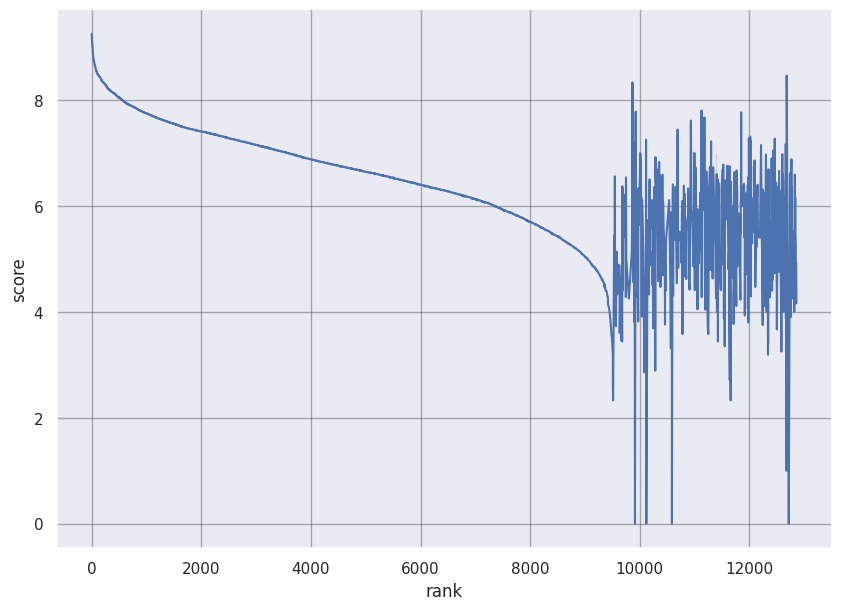

In [ ]:
plt.figure(figsize=(10,7))
sns.lineplot(x=anime_info['rank'],y=anime_info['score'])
sns.set_style(rc = {'axes.facecolor': 'ivory'})
plt.grid(alpha=0.3,color='black')

Аниме в жанре комедия и в жанрах связанных с фантастикой/приключениями выпускают больше всего. Значит ли это, что это жанры, которые большу всего нравятся аудитории ?
Посмотрим на распределение оценок для аниме каждого жанра.
Для этого сначала вытащим нужную информацию

In [ ]:
anime_info_copy = anime_info.copy()
anime_info_genre= anime_info_copy["genre"].str.split(', ').explode().reset_index(drop=True).to_frame()
anime_info_genre = anime_info_genre[anime_info_genre['genre'].notna()]
anime_info_array = anime_info_copy.to_numpy()
ind=0
for i in range(len(anime_info_array)) :
    if str(anime_info_array[i,24])=='nan' :
        for j in range(num):
            anime_info_genre.loc[ind,'score']=anime_info_array[i,14]
            ind+=1
        break
    num = len(anime_info_array[i,24].split(', '))
    for j in range(num):
        anime_info_genre.loc[ind,'score']=anime_info_array[i,14]
        ind+=1
genres=anime_info_copy["genre"].str.split(', ').explode().reset_index(drop=True).drop_duplicates().to_numpy()
print(anime_info_genre)

              genre  score
0            Comedy   7.63
1      Supernatural   7.89
2           Romance   7.55
3           Shounen   8.21
4            Comedy   8.67
...             ...    ...
23745       Romance    NaN
23746         Music    NaN
23747          Kids    NaN
23748          Kids    NaN
23749          Kids    NaN

[23746 rows x 2 columns]


Так как жанров много, распредление оценок изображу на нескольких плотах

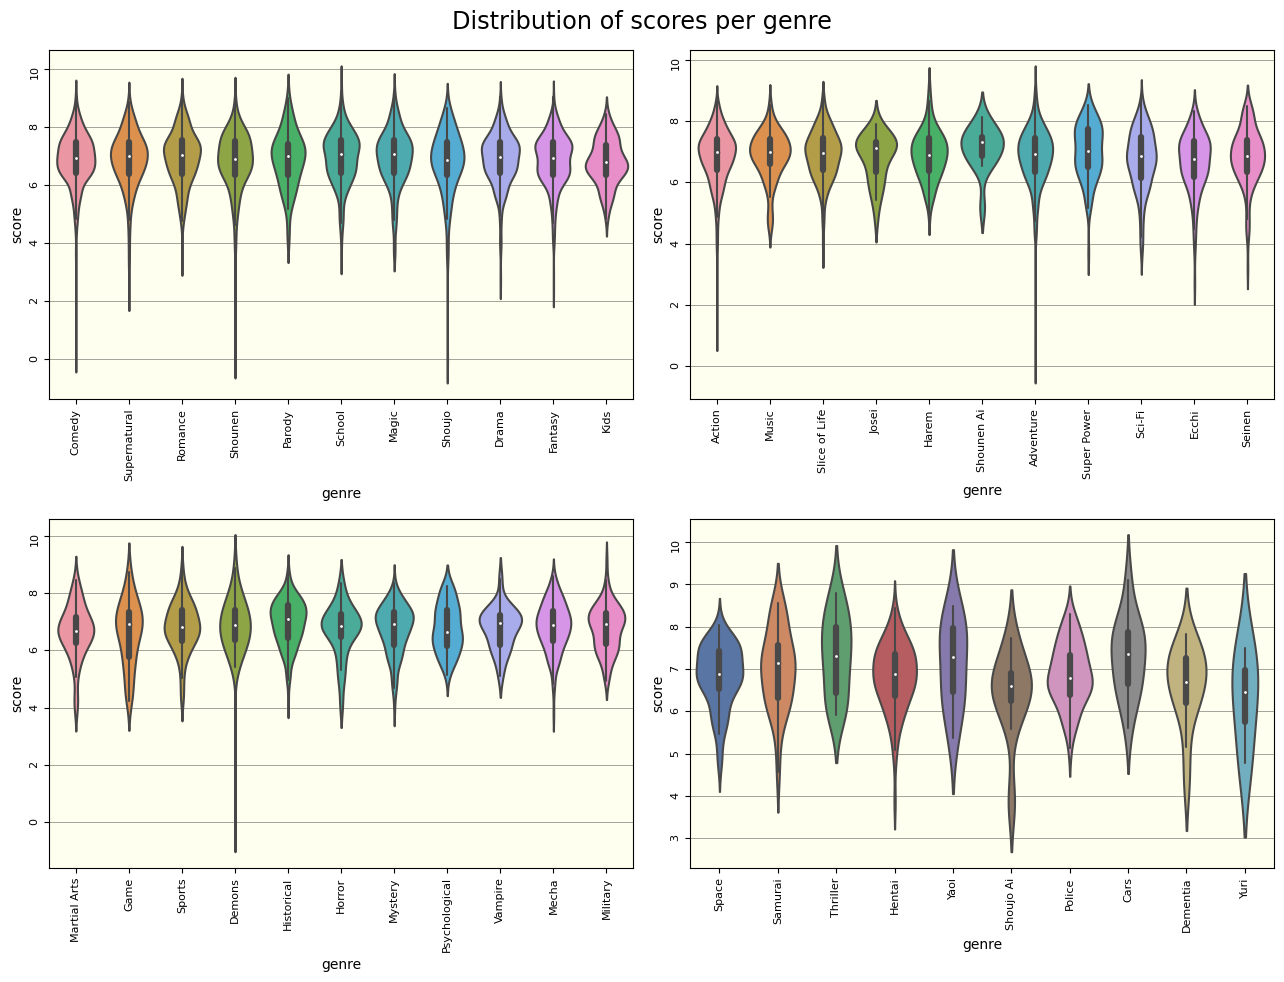

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(13, 10))
quater = int(len(genres)/4)
mid = int(len(genres)/2)
#setting design of graphs
plt.suptitle("Distribution of scores per genre",y=0.98,fontsize='xx-large')
sns.set(style="darkgrid")
rows, cols = 2, 2
for i in range(rows):
    for j in range(cols):
        axs[i,j].grid(linewidth=0.5,alpha=0.5,color ="black") #сетка
        axs[i,j].set_axisbelow(True)
        axs[i,j].tick_params(labelsize=8,labelrotation=90)
        axs[i, j].set_facecolor('ivory') #фоновый цвет
for i in range(4):
    part=genres[quater*i:quater*(i+1)]
    anime_part=anime_info_genre[(anime_info_genre['genre'].isin(part))]
    if i == 0 :
        sns.violinplot(x='genre', y="score", kind="violin",data=anime_part,ax=axs[0,0])
    elif i == 1:
        sns.violinplot(x='genre', y="score", kind="violin",data=anime_part,ax=axs[0,1])
    elif i == 2:
        sns.violinplot(x='genre', y="score", kind="violin",data=anime_part,ax=axs[1,0])
    else :
        sns.violinplot(x='genre', y="score", kind="violin",data=anime_part,ax=axs[1,1])
plt.tight_layout()

В целом кажется, что медианы не сильно отличаются. Стоит отметить, что здесь оценки пересекаются, т.к. одно аниме может относиться к нескольким жанрам. Однако мы все еще можем вычленить жанры в которых успешных аниме маловато, например: Space, Kids. Или успешные жанры: school, harem. Ну и те жанры успешность которых сильно зависит от исполнения:Dementia, Shoujo Ai.

Дальше мне стало интересно проверить связь между количеством серий в аниме и популярностью/оценками. И аналогично проверить связь длины тайтла аниме с популярностью/оценками. Для начала, построим скаттерплоты заивимости этих переменных.

Text(0.5, 0, 'num of letters in title')

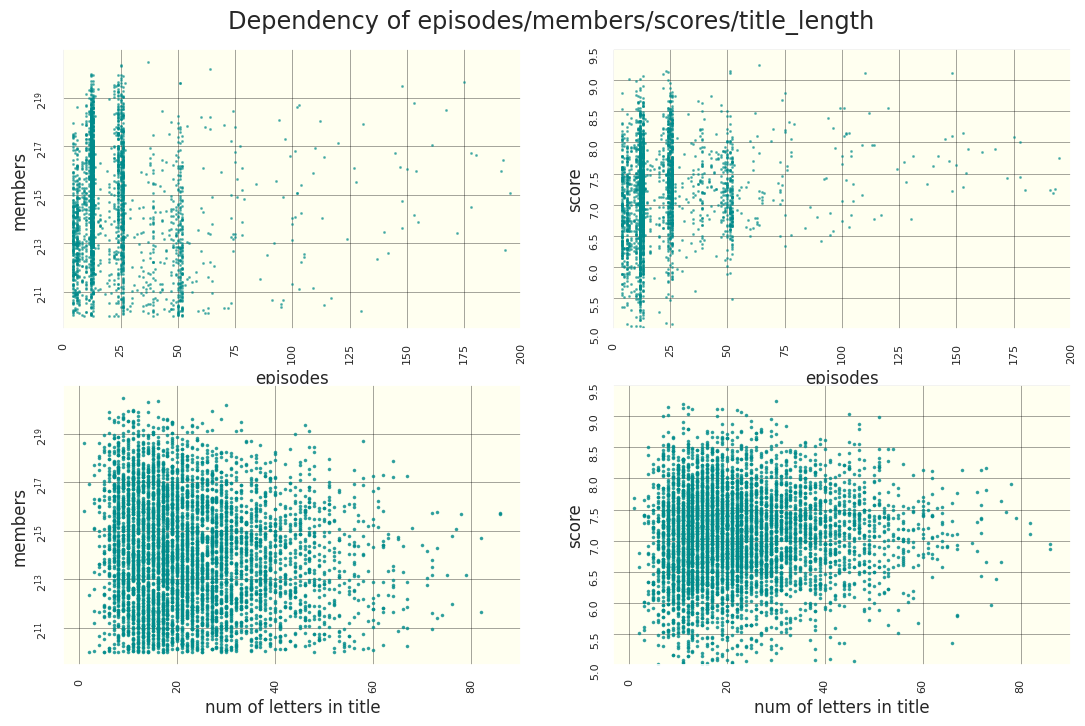

In [ ]:
#copying
anime_info_copy = anime_info.copy() #копия таблицы
#filtering
anime_info_copy= anime_info_copy[anime_info_copy['members'].astype(float)>1000]
anime_info_copy= anime_info_copy[anime_info_copy['score'].astype(float)>5]
anime_info_copy['title']=anime_info_copy['title'].str.replace(" ", "").str.len()
anime_series=anime_info_copy.loc[(anime_info_copy['episodes'].astype(float)>3)]
# graphics and stuff
fig, axs = plt.subplots(2,2,figsize=(13, 8))
rows, cols = 2, 2
plt.suptitle("Dependency of episodes/members/scores/title_length",y=0.93,fontsize='x-large')
for i in range(rows):
    for j in range(cols):
        axs[i,j].tick_params(labelsize=8,labelrotation=90)
        axs[i,j].grid(linewidth=0.5,alpha=0.5,color ="black") #сетка
        axs[i,j].set_axisbelow(True)
        axs[i, j].set_facecolor('ivory') #фоновый цвет
        if i == 0:
            axs[i,j].set_xlim([0,200])
        if j == 1:
            axs[i,j].set_ylim([5, 9.5])
#top left
x,y= anime_series['episodes'],anime_series['members']
axs[0,0].set_yscale('log',base=2)
axs[0,0].scatter(x,y, marker=".",color="darkcyan",alpha=0.5,s=5)#scatterplot
axs[0,0].set_ylabel('members')
axs[0,0].set_xlabel('episodes')
#top right
x,y=anime_series['episodes'], anime_series['score']
axs[0,1].scatter(x,y, marker=".",color="darkcyan",alpha=0.5,s=5)#scatterplot
axs[0,1].set_ylabel('score')
axs[0,1].set_xlabel('episodes')
#bottom left
x,y=anime_info_copy['title'], anime_info_copy['members']
axs[1,0].scatter(x,y, marker=".",color="darkcyan",alpha=0.7,s=10)#scatterplot
axs[1,0].set_yscale('log',base=2)
axs[1,0].set_ylabel('members')
axs[1,0].set_xlabel('num of letters in title')
#bottom right
x,y=anime_info_copy['title'], anime_info_copy['score']
axs[1,1].scatter(x,y, marker=".",color="darkcyan",alpha=0.7,s=10)#scatterplot
axs[1,1].set_ylabel('score')
axs[1,1].set_xlabel('num of letters in title')

Для большей содержательности я показываю только значения для аниме с кол-вом эпизодов меньше 200 и количеством участников больше 1000. Смотря на скаттерплот, трудно установить тенденцию т.к с увеличением количества эпизодов/букв в названии, аниме с таким параметром становится меньше.

Классифицируем наши данные и проверим статистически, зависимы ли эти переменные

In [ ]:
warnings.filterwarnings('ignore')
def series_class(num_ep):
    """
    Cringe-function that classifies numeric values
    """
    if np.isnan(num_ep) == False:
        if num_ep<=12:
            return '<=12'
        elif 12<num_ep<=24:
            return '<=24'
        else :
            return '24+'
    else : return np.nan
def members_class(num_mem):
    """
    Cringe-function that classifies numeric values
    """
    if pd.isnull(num_mem) == False:
        for i in range(20):
            if num_mem in range(i*50000,(i+1)*50000):
                if i*100000>= 400000:
                    return '400000+'
                else :
                    return f'{i*50000,(i+1)*50000}'
    else : return np.nan
def score_class(num_score):
    """
    Cringe-function that classifies numeric values
    """
    if np.isnan(num_score) == False:
        for i in range(20):
            if num_score <= 6 :
                return '<=6'
            elif num_score >=8.5:
                return '>=8.5'
            else :
                if i*0.5 <= num_score and num_score <= (i+1)*0.5:
                    return f'{i*0.5,(i+1)*0.5}'

    else : return np.nan
def title_class(num_title):
    """
    Cringe-function that classifies numeric values
    """
    if pd.isnull(num_title) == False:
        for i in range(20):
            if num_title >= 40 :
                return '40+'
            elif  0<num_title<10:
                return '<10'
            else:
                if i*5 <= num_title and num_title < (i+1)*5:
                    return f'{i*5,(i+1)*5}'
    else : return np.nan

#copying
anime_info_copy = anime_info.copy() #копия таблицы
#filtering
anime_info_copy= anime_info_copy[anime_info_copy['members'].astype(float)>1000]
anime_info_copy= anime_info_copy[anime_info_copy['score'].astype(float)>5]
anime_info_copy['title']=anime_info_copy['title'].str.replace(" ", "").str.len()
anime_series=anime_info_copy.loc[(anime_info_copy['episodes'].astype(float)>3)]
#classification functions applied
#excluding Movies, ovas/onas
anime_series['episodes'] = anime_series['episodes'].apply(series_class)
anime_series['members'] = anime_series['members'].apply(members_class)
anime_series['score'] = anime_series['score'].apply(score_class)
#all since the numbers of episodes doesn't matter
anime_info_copy['title'] = anime_info_copy['title'].apply(title_class)
anime_info_copy['members'] = anime_info_copy['members'].apply(members_class)
anime_info_copy['score'] = anime_info_copy['score'].apply(score_class)
#episodes vs members
ep_mem =pd.crosstab(anime_series['episodes'], anime_series['members'])
c, p, dof, expected = scipy.stats.chi2_contingency(ep_mem)
if p < 0.01 :
    print(f'Связь между episodes и members есть т.к p-value - {p}')
else: print(f'Связи между episodes и members нет т.к p-value - {p}')
#episodes vs scores
ep_score =pd.crosstab(anime_series['episodes'], anime_series['score'])
c, p, dof, expected = scipy.stats.chi2_contingency(ep_score)
if p < 0.01 :
    print(f'Связь между episodes и score есть т.к p-value - {p}')
else: print(f'Связи между episodes и score нет т.к p-value - {p}')
#title length vs scores
title_score =pd.crosstab(anime_info_copy['title'], anime_info_copy['score'])
c, p, dof, expected = scipy.stats.chi2_contingency(title_score)
if p < 0.01 :
    print(f'Связь между title length и score есть т.к p-value - {p}')
else: print(f'Связи между title length и score нет т.к p-value - {p}')
#title length vs members
title_members =pd.crosstab(anime_info_copy['title'], anime_info_copy['members'])
c, p, dof, expected = scipy.stats.chi2_contingency(title_members)
if p < 0.01 :
    print(f'Связь между title length и members есть т.к p-value - {p}')
else:
    print(f'Связи между title length и members нет т.к p-value - {p}')

Связь между episodes и members есть т.к p-value - 1.0043041250675357e-11
Связь между episodes и score есть т.к p-value - 2.8316937229515575e-30
Связь между title length и score есть т.к p-value - 1.4908011003109258e-06
Связь между title length и members есть т.к p-value - 1.787480540054258e-17


Если хочется посмотреть таблицы на основе которых был проведен тест:

In [ ]:
# ep_members or ep_score or title_score or title_members
title_score

score,"(6.0, 6.5)","(6.5, 7.0)","(7.0, 7.5)","(7.5, 8.0)","(8.0, 8.5)",<=6,>=8.5
title,,,,,,,
"(10, 15)",164,240,269,183,87,99,16
"(15, 20)",123,230,285,195,101,83,22
"(20, 25)",101,230,235,154,53,56,17
"(25, 30)",78,193,171,108,39,40,16
"(30, 35)",51,102,133,83,36,27,6
"(35, 40)",41,63,106,70,25,19,7
40+,64,150,211,107,44,26,8
<10,99,136,150,83,44,57,14


Далее мне стало интересно посмотреть насколько одинаково или по разному м/ж пол оценивают аниме разных жанров.

In [ ]:
#analysis for particular genre
genre=input("name a genre, for ex: Horror. ")
#filtering animes with chosen genre
an_info_ar = anime_info.copy()
an_info_ar['genre']=anime_info["genre"].str.split(', ')
an_info_ar= an_info_ar.to_numpy()
df_all = pd.DataFrame(columns=['my_score'])
p_values=[]
for ind in range(len(an_info_ar)) :
    try:
        if genre in an_info_ar[ind,-5]:
            # testing whether genders simmilarly rate genre
            anime_id= an_info_ar[ind,0]
            df_scores = animelist.loc[animelist['anime_id'] == anime_id][['username','my_score']]#getting all usernames and their scores for respective anime of respective genre
            df_scores = df_scores.set_index('username')
            df_merged=df_scores.join(animeusers,rsuffix="_second", how="left") #merging table with scores and usernames with table that has info about sex of users
            df_genders_m = df_merged.loc[df_merged['gender']=='Male']['my_score'].reset_index(drop=True)
            df_genders_f = df_merged.loc[df_merged['gender']=='Female']['my_score'].reset_index(drop=True)
            df_genders = pd.concat([df_genders_m, df_genders_f], axis=1).astype(float)
            df_genders.columns= ['Male','Female']
            female_info=df_genders['Female'].dropna()
            male_info=df_genders['Male'].dropna()
            stat, p_value = scipy.stats.mannwhitneyu (male_info, female_info, alternative='two-sided')
            p_values.append(p_value)
    except:
        continue
#adj_p_values=st.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=Falseб, returnsorted=False)
adj_p_values= statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False)
bools=adj_p_values[0]
ratio = sum(bools)/len(bools)
print(f'Из всех аниме жанра {genre} в {ratio} части был обнаружен перекос голосов от м/ж')

name a genre, for ex: Horror. Horror
Из всех аниме жанра Horror в 0.40625 части был обнаружен перекос голосов от м/ж


Для проверки наличия перекоса в каждом аниме выбранного жанра был использован непараметрический тест, т.к. оценки, которые ставят юзеры могут принимать лишь 11 значений (0,10). Тут на нормальность не приходится расчитывать

Интересно также одинаково ли оцениваются олдскульные аниме и аниме нового поколения. Для этого я разделю все аниме на 2 класса : вышедшие до 2010 будем считать олдскулом, а после 2010 new gen (их примерно одинаковое число)

In [ ]:
anime_copy = anime_info.copy()
anime_copy=anime_copy[anime_copy['score'].astype(float)>5]
date= anime_copy
date['aired_string']=date['aired_string'].str.split('to').str[0]
for i in range(len(anime_copy['aired_string'].to_numpy())):
    changed_col= pd.to_datetime(date['aired_string'].iloc[i].strip(),format="%b %d, %Y",errors="coerce",utc=True)
    anime_copy['aired_string'].iloc[i]=changed_col.to_pydatetime()
anime_copy = anime_copy[anime_copy['aired_string'].notna()]
anime_copy['year'] = pd.DatetimeIndex(anime_copy['aired_string']).year # retieving year of release of each anime

below_2010= anime_copy[anime_copy['year'].astype(float)<2010]
below_2010['type']='below 2010'
above_2010= anime_copy[anime_copy['year'].astype(float)>=2010] #including
above_2010['type']='above 2010'
df_concat = pd.concat([below_2010[['score','type']], above_2010[['score','type']]])
df_concat

,score,type
1,7.89,below 2010
2,7.55,below 2010
3,8.21,below 2010
5,8.03,below 2010
6,7.26,below 2010
...,...,...
6655,6.00,above 2010
6657,6.04,above 2010
6660,7.80,above 2010
6662,7.53,above 2010


Проверю свои данные на нормальность. Оценки за аниме все-таки оценки за аниме могу принимать не целые значения

Проверяю данные (оценки за аниме) на нормальность. P-value разными тестами:
Выборка 1 (ДО 2010)
Колмогоров-Смирнов:0.0
Шапиро-уилка:0.0005658626323565841

Выборка 2 (ПОСЛЕ 2010 включительно)
Колмогоров-Смирнов:0.0
Шапиро-уилка:6.20790974181773e-10

Проверяю одинаково ли оценивают аниме (нулевая гипотеза), вышедшие до 2010 года и после 2010 (включительно)
На 1% уровне значимости продолжаем верить в нулевую гипотезу, т.к p_value = 0.021898441781442256


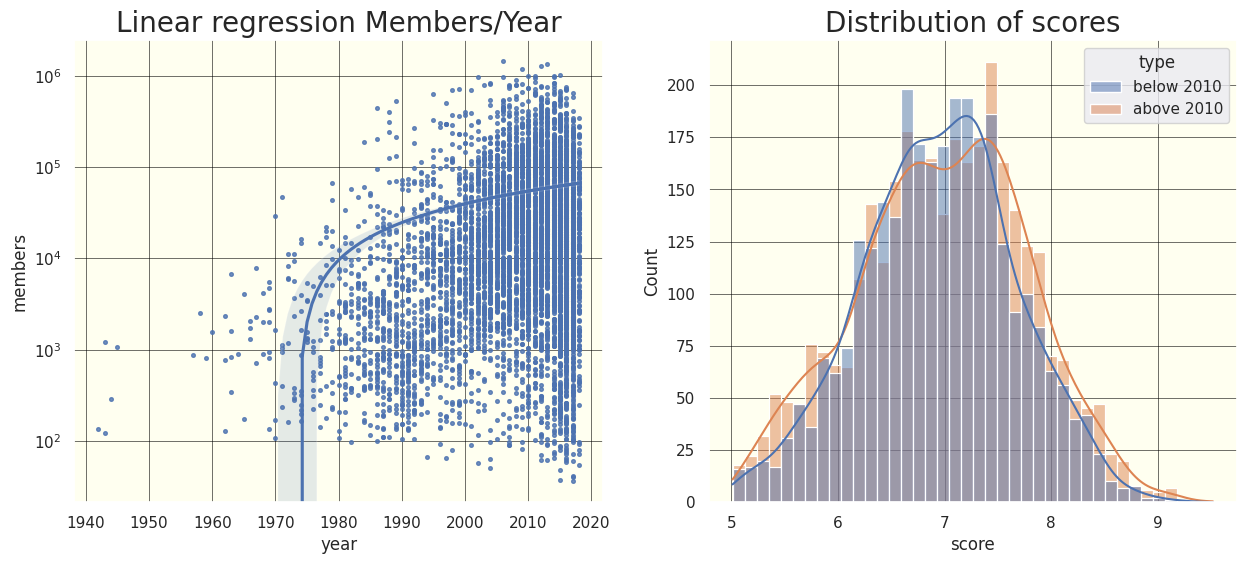

In [ ]:
#checking normality of scores for 2 samples
print('Проверяю данные (оценки за аниме) на нормальность. P-value разными тестами:')
print('Выборка 1 (ДО 2010)')
print(f"Колмогоров-Смирнов:{scipy.stats.kstest(below_2010['score'], 'norm')[1]}")
print(f"Шапиро-уилка:{scipy.stats.shapiro(below_2010['score']).pvalue}")
print('\nВыборка 2 (ПОСЛЕ 2010 включительно)')
print(f"Колмогоров-Смирнов:{scipy.stats.kstest(above_2010['score'], 'norm')[1]}")
print(f"Шапиро-уилка:{scipy.stats.shapiro(above_2010['score']).pvalue}\n")
# я плачу потому что хочу хоть один параметрический тест
print('Проверяю одинаково ли оценивают аниме (нулевая гипотеза), вышедшие до 2010 года и после 2010 (включительно)')
stat, p_value = scipy.stats.mannwhitneyu (below_2010['score'], above_2010['score'], alternative='two-sided')
if p_value > 0.01 :
    print(f'На 1% уровне значимости продолжаем верить в нулевую гипотезу, т.к p_value = {p_value}')
else :
    print(f'На 1% уровне значимости отвергаем нулевую гипотезу, т.к p_value = {p_value}')


fig, axs = plt.subplots(1,2,figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.yscale('log',base=10)
sns.regplot(data=anime_copy,x='year',y='members',scatter_kws=dict(s=7),logx=True)
plt.subplot(1, 2, 2)
sns.histplot(x='score',hue="type",kde=True,data=df_concat)
axs[0].set_title('Linear regression Members/Year', fontsize = '20')
axs[1].set_title('Distribution of scores', fontsize = '20')
for i in range(2):
    axs[i].set_facecolor('ivory')
    axs[i].grid(linewidth=0.5,alpha=0.8,color ="black") #сетка
    axs[i].set_axisbelow(True)

Тесты, к сожалению, гласят, что данные не распределены нормально, хотя смотря на график распределения значений, надежда была. Одинаково ли все-таки оцениваются аниме до 2010 и после? Тут спорно. На 5% уровне значемости поверить в это можно, на 1% - нет

Также я решил показать наличие линейной связи между тем, когда вышло аниме и насколько оно популярно. Учитывая, логарифмическую шкалу, мы наблюдаем что-то похожее на линейную зависимость

Запусти, чтоб выбрать аниме для просмотра :

In [ ]:
anime_list = list(anime_info[anime_info['score']>8]["title"])
random_index = random.randint(0,len(anime_list)-1)
print(anime_list[random_index])

Samurai Champloo
